### Analysing an Adapted PRSH Trader

import improved PRSH from separate file
analyse how changing parameters affect it in similar way to above?
compare optimised parameter EPRSH and PRSH in each market to compare performance?

In [9]:
# Imports

import matplotlib.pyplot as plt
import numpy as np
import csv
import math
import random
import pandas as pd
import importlib
import scipy.stats as sp

import BSE_PRSH2
importlib.reload(BSE_PRSH2) # important to ensure most recent version of BSE used 
from BSE_PRSH2 import market_session, set_PRSH_parameters

# graphing functions from BSE Intro Practical 


# Use this to plot trades of a single experiment
def plot_trades(trial_id):
    prices_fname = trial_id + '_transactions.csv'
    x = np.empty(0)
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = float(row[1])
            price = float(row[2])
            x = np.append(x,time)
            y = np.append(y,price)

    plt.plot(x, y, 'x', color='black') 
    
# Use this to run an experiment n times and plot all trades
def n_runs_plot(n, trial_id, start_time, end_time, traders_spec, order_sched):
    x = np.empty(0)
    y = np.empty(0)

    for i in range(n):
        trialId = trial_id + '_' + str(i)
        tdump = open(trialId + '_avg_balance.csv','w')

        market_session(trialId, start_time, end_time, traders_spec, order_sched, tdump, True, False)
        
        tdump.close()

        with open(trialId + '_transactions.csv', newline='') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                time = float(row[1])
                price = float(row[2])
                x = np.append(x,time)
                y = np.append(y,price)

    plt.plot(x, y, 'x', color='black');

# !!! Don't use on it's own   
def getorderprice(i, sched, n, mode):
    pmin = min(sched[0][0], sched[0][1])
    pmax = max(sched[0][0], sched[0][1])
    prange = pmax - pmin
    stepsize = prange / (n - 1)
    halfstep = round(stepsize / 2.0)

    if mode == 'fixed':
        orderprice = pmin + int(i * stepsize)
    elif mode == 'jittered':
        orderprice = pmin + int(i * stepsize) + random.randint(-halfstep, halfstep)
    elif mode == 'random':
        if len(sched) > 1:
            # more than one schedule: choose one equiprobably
            s = random.randint(0, len(sched) - 1)
            pmin = min(sched[s][0], sched[s][1])
            pmax = max(sched[s][0], sched[s][1])
        orderprice = random.randint(pmin, pmax)
    return orderprice    

# !!! Don't use on it's own
def make_supply_demand_plot(bids, asks, title):
    # total volume up to current order
    volS = 0
    volB = 0

    fig, ax = plt.subplots()
    plt.ylabel('Price')
    plt.xlabel('Quantity')
    plt.title(title)
    pr = 0
    for b in bids:
        if pr != 0:
            # vertical line
            ax.plot([volB,volB], [pr,b], 'r-')
        # horizontal lines
        line, = ax.plot([volB,volB+1], [b,b], 'r-')
        volB += 1
        pr = b
    if bids:
        line.set_label('Demand')
        
    pr = 0
    for s in asks:
        if pr != 0:
            # vertical line
            ax.plot([volS,volS], [pr,s], 'b-')
        # horizontal lines
        line, = ax.plot([volS,volS+1], [s,s], 'b-')
        volS += 1
        pr = s
    if asks:
        line.set_label('Supply')
        
    if bids or asks:
        plt.legend()
    plt.show()

# Use this to plot supply and demand curves from supply and demand ranges and stepmode
def sup_dem(seller_num, sup_ranges, buyer_num, dem_ranges, stepmode, title):
    asks = []
    for s in range(seller_num):
        asks.append(getorderprice(s, sup_ranges, seller_num, stepmode))
    asks.sort()
    bids = []
    for b in range(buyer_num):
        bids.append(getorderprice(b, dem_ranges, buyer_num, stepmode))
    bids.sort()
    bids.reverse()
    
    make_supply_demand_plot(bids, asks, title) 

# plot sorted trades, useful is some situations - won't be used in this worksheet
def in_order_plot(trial_id):
    prices_fname = trial_id + '_transactions.csv'
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            price = float(row[2])
            y = np.append(y,price)
    y = np.sort(y)
    x = list(range(len(y)))

    plt.plot(x, y, 'x', color='black')   

In [5]:
# Experimental setup
dir = r'C:\Users\Joe\OneDrive\Documents\Actual Docs\Bristol\ITFT\ITFT-Coursework-Assessment\market_outputs\\'

balanced_sellers_spec = [("ZIP", 5),("ZIC", 5),("PRSH", 5), ("SHVR", 5), ("GVWY", 5)]
balanced_buyers_spec = balanced_sellers_spec
balanced_traders_spec = {"sellers":balanced_sellers_spec, "buyers":balanced_buyers_spec}

start_time = 0
end_time = 3000 # needs to be long to allow for different strats to be tried

def csv_prep(fname, total_traders):
    dir = r'C:\Users\Joe\OneDrive\Documents\Actual Docs\Bristol\ITFT\ITFT-Coursework-Assessment\market_outputs\\'
    tdump = open(dir + fname, 'w')

    # annotate columns
    tdump.write('%s, %s,%s,%s, ' % ('expid', 'time','best bid','best offer')) 
    for f in range(total_traders):
            tdump.write('%s, %s, %s, %s, ' % ('type', 'balance', 'number of traders', 'profit per trader'))
    tdump.write('%s, %s, ' % ('best bid','best offer'))
    tdump.write('\n');
    return tdump


In [6]:
## M1 experiment - symmetric supply/demand, range (10, 50), fixed stepmode, drip jitter order interval

# CSV preparation

fname = 'PRSH2_pairwise_m1.csv'
tdump = csv_prep(fname, total_traders = 6)

sup_range = (10, 50)
dem_range = sup_range

supply_schedule = [{'from':start_time, 'to':end_time, "ranges":[sup_range], "stepmode":"fixed"}]
demand_schedule = supply_schedule

order_interval = 10
order_sched = {"sup":supply_schedule, "dem":demand_schedule, "interval":order_interval,"timemode":"drip-jitter"}

trial = 0
trials_per_ratio = 10
total_traders = 5

for j in range (1, total_traders):
    sellers_spec = [("PRSH", j), ("PRSH2", total_traders - j)]
    buyers_spec = sellers_spec
    traders_spec = {"sellers": sellers_spec, "buyers": buyers_spec}

    sup_range = (10, 50)
    dem_range = sup_range

    supply_schedule = [{'from':start_time, 'to':end_time, "ranges":[sup_range], "stepmode":"fixed"}]
    demand_schedule = supply_schedule

    order_interval = 10
    order_sched = {"sup":supply_schedule, "dem":demand_schedule, "interval":order_interval,"timemode":"drip-jitter"}
    
    while trial <  j * trials_per_ratio:
            market_session(trial, start_time, end_time, traders_spec, order_sched, tdump, False, True)
            tdump.flush()
            trial += 1 


0;  

1;  

2;  

3;  

4;  

5;  

6;  

7;  

8;  

9;  

10;  

11;  

12;  

13;  

14;  

15;  

16;  

17;  

18;  

19;  

20;  

21;  

22;  

23;  

24;  

25;  

26;  

27;  

28;  

29;  

30;  

31;  

32;  

33;  

34;  

35;  

36;  

37;  

38;  

39;  


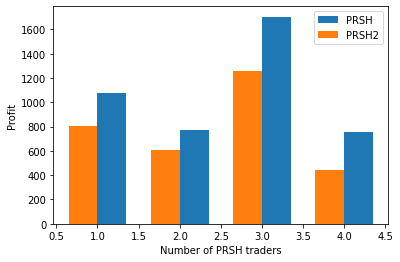

In [15]:
# Visualising profit per trader as trader number varies

trades_df = pd.read_csv(dir + 'PRSH2_pairwise_m1' + '.csv')
trades_df.columns = trades_df.columns.str.strip()

trades_df = trades_df.loc[:,['profit per trader', 'number of traders', 'profit per trader.1']]

groups = trades_df.groupby(pd.Grouper(key='number of traders')).sum()

label1 = "PRSH"
width = 0.35

for key in groups:

    plt.bar(groups.get(key).index.to_numpy()/2 + width/2, groups.get(key).values, np.abs(width), label = label1)
    plt.xlabel("Number of PRSH traders")
    plt.ylabel("Profit")
    width = -width
    label1 = "PRSH2"
    plt.legend()

plt.show()

Softmax appears worse 
DO NOT RUN AGAIN, PRSH2 CODE CHANGED TO A DIFFERENT ALGO    

In [6]:
## M1 experiment - symmetric supply/demand, range (10, 50), fixed stepmode, drip jitter order interval

# CSV preparation

fname = 'PRSH2_pairwise_greedy_m1.csv'
tdump = csv_prep(fname, total_traders = 6)

sup_range = (10, 50)
dem_range = sup_range

supply_schedule = [{'from':start_time, 'to':end_time, "ranges":[sup_range], "stepmode":"fixed"}]
demand_schedule = supply_schedule

order_interval = 10
order_sched = {"sup":supply_schedule, "dem":demand_schedule, "interval":order_interval,"timemode":"drip-jitter"}

trial = 0
trials_per_ratio = 10
total_traders = 5

for j in range (1, total_traders):
    sellers_spec = [("PRSH", j), ("PRSH2", total_traders - j)]
    buyers_spec = sellers_spec
    traders_spec = {"sellers": sellers_spec, "buyers": buyers_spec}

    sup_range = (10, 50)
    dem_range = sup_range

    supply_schedule = [{'from':start_time, 'to':end_time, "ranges":[sup_range], "stepmode":"fixed"}]
    demand_schedule = supply_schedule

    order_interval = 10
    order_sched = {"sup":supply_schedule, "dem":demand_schedule, "interval":order_interval,"timemode":"drip-jitter"}
    
    while trial <  j * trials_per_ratio:
            market_session(trial, start_time, end_time, traders_spec, order_sched, tdump, False, True)
            tdump.flush()
            trial += 1 


0;  

1;  

2;  

3;  

4;  

5;  

6;  

7;  

8;  

9;  

10;  

11;  

12;  

13;  

14;  

15;  

16;  

17;  

18;  

19;  

20;  

21;  

22;  

23;  

24;  

25;  

26;  

27;  

28;  

29;  

30;  

31;  

32;  

33;  

34;  

35;  

36;  

37;  

38;  

39;  


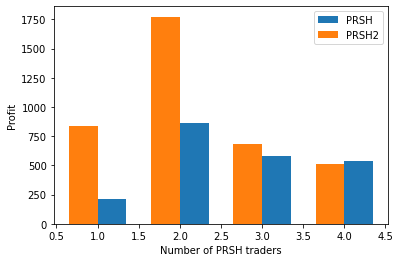

In [8]:
# Visualising profit per trader as trader number varies

trades_df = pd.read_csv(dir + 'PRSH2_pairwise_greedy_m1' + '.csv')
trades_df.columns = trades_df.columns.str.strip()

trades_df = trades_df.loc[:,['profit per trader', 'number of traders', 'profit per trader.1']]

groups = trades_df.groupby(pd.Grouper(key='number of traders')).sum()

label1 = "PRSH"
width = 0.35

for key in groups:

    plt.bar(groups.get(key).index.to_numpy()/2 + width/2, groups.get(key).values, np.abs(width), label = label1)
    plt.xlabel("Number of PRSH traders")
    plt.ylabel("Profit")
    width = -width
    label1 = "PRSH2"
    plt.legend()

plt.show()

Statistical test!

In [19]:
# Vary epsilon

# CSV preparation

fname = 'PRSH2_greedy_epsilon_m1.csv'
tdump = csv_prep(fname, total_traders = 6)

balanced_sellers_spec = [("ZIP", 5),("ZIC", 5),("PRSH", 5), ("SHVR", 5), ("GVWY", 5)]
balanced_buyers_spec = balanced_sellers_spec
balanced_traders_spec = {"sellers":balanced_sellers_spec, "buyers":balanced_buyers_spec}

sup_range = (10, 50)
dem_range = sup_range

supply_schedule = [{'from':start_time, 'to':end_time, "ranges":[sup_range], "stepmode":"fixed"}]
demand_schedule = supply_schedule

order_interval = 10
order_sched = {"sup":supply_schedule, "dem":demand_schedule, "interval":order_interval,"timemode":"drip-jitter"}

trials_per_eps = 10
trial = 0
eps_iteration = 0 
epsilons = np.arange(0, 0.5, 0.05)
for eps in epsilons:
        eps_iteration += 1
        set_PRSH_parameters(eps1 = eps)
        while trial < eps_iteration * trials_per_eps:
                market_session(trial, start_time, end_time, balanced_traders_spec, order_sched, tdump, False, True)
                tdump.flush()
                trial = trial + 1


0;  

1;  

2;  

3;  

4;  

5;  

6;  

7;  

8;  

9;  

10;  

11;  

12;  

13;  

14;  

15;  

16;  

17;  

18;  

19;  

20;  

21;  

22;  

23;  

24;  

25;  

26;  

27;  

28;  

29;  

30;  

31;  

32;  

33;  

34;  

35;  

36;  

37;  

38;  

39;  

40;  

41;  

42;  

43;  

44;  

45;  

46;  

47;  

48;  

49;  

50;  

51;  

52;  

53;  

54;  

55;  

56;  

57;  

58;  

59;  

60;  

61;  

62;  

63;  

64;  

65;  

66;  

67;  

68;  

69;  

70;  

71;  

72;  

73;  

74;  

75;  

76;  

77;  

78;  

79;  

80;  

81;  

82;  

83;  

84;  

85;  

86;  

87;  

88;  

89;  

90;  

91;  

92;  

93;  

94;  

95;  

96;  

97;  

98;  

99;  


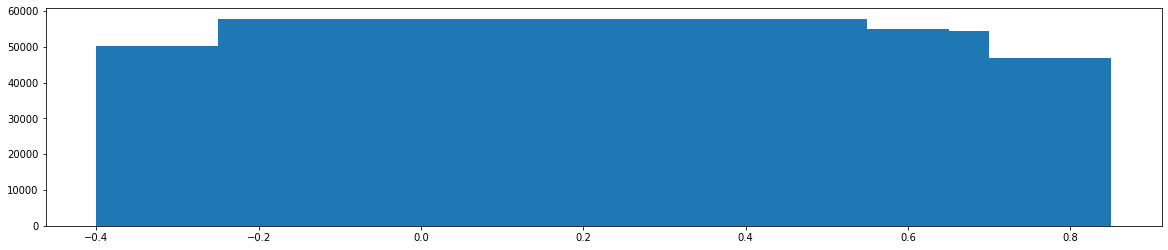

In [20]:
fig, axs = plt.subplots(figsize=(20,4), nrows=1, ncols=1)

cumulative_profit = np.zeros(8) 
cumulative_df = pd.DataFrame()

trades_df = pd.read_csv(dir+fname)

# Just PRSH performance, grouped by k values
PRSH_df = trades_df.iloc[:,8:10]
PRSH_df = PRSH_df.assign(eps = np.repeat(epsilons, trials_per_eps))
groups = PRSH_df.groupby(pd.Grouper(key='eps')).sum()

for key in groups:
    plt.bar(groups.get(key).index.to_numpy(), groups.get(key).values)
    
plt.show()